# Co-clustering

This notebook illustrates how to use [Clustering Geo-data Cubes (CGC)](https://cgc.readthedocs.io) to perform a co-clustering analysis of geo-spatial data. 

Note that in addition to CGC, whose installation instructions can be found [here](https://github.com/phenology/cgc), few other packages are required in order to run this notebook. Please have a look at this tutorial's [installation instructions](https://github.com/escience-academy/tutorial-cgc). 

## The data

The data employed in this tutorial is a subset of the first-bloom spring-index calculated for the conterminous US from 1980 to 2015 at 1 km resolution. The data set has been cropped to an area that is (700 km x 700 km) large, approximately corresponding to the State of Washington, and only the last 15 years have been considered. The data is provided as a set of 15 GeoTiff files (one per year, labelled accordingly).
For more information about the data have a look at the original publication https://doi.org/10.1016/j.agrformet.2018.06.028 - please cite this reference if you use the data!

## Imports and general configuration

In [1]:
import cgc
import logging
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from cgc.coclustering import Coclustering
from cgc.kmeans import Kmeans
from dask.distributed import Client

print(f'CGC version: {cgc.__version__}')

CGC version: 0.2.1


CGC makes use of `logging`, set the desired verbosity via:

In [2]:
logging.basicConfig(level=logging.INFO)

## Reading the data

We use `xarray` to read the data (via `rasterio`), creating a single array (a `DataArray`) that includes the spring-index in both the spatial and temporal dimensions:

In [3]:
years = range(2001, 2016)
spring_index = [xr.open_rasterio(f'../data/{year}.tif') for year in years]
spring_index = xr.concat(spring_index, dim='time')
spring_index = spring_index.squeeze('band', drop=True)  # drop band dimension

# set year as time coordinate
spring_index = spring_index.assign_coords(year=('time', years))

We manipulate the spatial dimensions, creating a combined (x,y) index, and drop all 'pixels' that are null-valued for any of the years considered:

In [4]:
spring_index = spring_index.stack(space=['x', 'y'])
location = np.arange(spring_index.space.size) # create a combined (x,y) index
spring_index = spring_index.assign_coords(location=('space', location))

# drop pixels that are null-valued for any of the time indices
spring_index = spring_index.dropna('space', how='any')  
print(spring_index)

<xarray.DataArray (time: 15, space: 490000)>
array([[130., 130., 130., ...,  60.,  60.,  60.],
       [120., 120., 120., ...,  66.,  66.,  66.],
       [137., 137., 137., ...,  62.,  62.,  62.],
       ...,
       [123., 123., 123., ...,  65.,  65.,  66.],
       [118., 118., 118., ...,  53.,  53.,  53.],
       [109., 110., 110., ...,  57.,  56.,  56.]], dtype=float32)
Coordinates:
    year      (time) int64 2001 2002 2003 2004 2005 ... 2011 2012 2013 2014 2015
  * space     (space) MultiIndex
  - x         (space) float64 -126.3 -126.3 -126.3 ... -120.0 -120.0 -120.0
  - y         (space) float64 49.25 49.24 49.23 49.22 ... 43.0 42.99 42.98 42.97
    location  (space) int64 0 1 2 3 4 5 ... 489995 489996 489997 489998 489999
Dimensions without coordinates: time
Attributes:
    transform:      (0.008983152841195215, 0.0, -126.30312894720473, 0.0, -0....
    crs:            +init=epsg:4326
    res:            (0.008983152841195215, 0.008983152841195215)
    is_tiled:       0
    nodatav

The data is now ready for the co-clustering analysis!

## Co-clustering

### Overview



### Numpy-based implementation

In [5]:
num_time_clusters = 3  # initial number of time (row) clusters
num_space_clusters = 5  # initial number of space (column) clusters

cc = Coclustering(
    spring_index.data,
    num_time_clusters,
    num_space_clusters,  
    max_iterations=10,  # maximum number of iterations
    conv_threshold=0.1,  # convergence threshold
    nruns=2  # number of differently-initialized runs
)

In [6]:
results = cc.run_with_threads(nthreads=1)

INFO:cgc.coclustering:Retrieving run 0
INFO:cgc.coclustering:Error = -2193930211.79061
INFO:cgc.coclustering:Retrieving run 1
INFO:cgc.coclustering:Error = -2193964251.1175003


In [7]:
results = cc.run_with_threads(nthreads=1)
print(f"Number of runs completed: {results.nruns_completed}")

INFO:cgc.coclustering:Retrieving run 2
INFO:cgc.coclustering:Error = -2193955091.360458
INFO:cgc.coclustering:Retrieving run 3
INFO:cgc.coclustering:Error = -2193955173.5615797


Number of runs completed: 4


In [8]:
print(f"Row (time) clusters: {results.row_clusters}")
print(f"Column (space) clusters: {results.col_clusters}")

Row (time) clusters: [0 1 2 0 1 2 1 0 2 0 1 1 0 2 2]
Column (space) clusters: [1 1 1 ... 3 3 3]


### Reducing the memory footprint

### Co-clustering with Dask

In [9]:
spring_index_da = spring_index.chunk((15, 122500))
print(spring_index_da.data)

dask.array<xarray-<this-array>, shape=(15, 490000), dtype=float32, chunksize=(15, 122500), chunktype=numpy.ndarray>


In [10]:
cc = Coclustering(
    spring_index_da.data,
    num_time_clusters,
    num_space_clusters,  
    max_iterations=10,  # maximum number of iterations
    conv_threshold=0.1,  # convergence threshold
    nruns=2  # number of differently-initialized runs
)

In [11]:
client = Client()
print(client)

<Client: 'tcp://127.0.0.1:59628' processes=4 threads=8, memory=17.18 GB>


In [12]:
results_da = cc.run_with_dask(client=client, low_memory=True)

INFO:cgc.coclustering:Run 0
INFO:cgc.coclustering:Error = -2193959223.934449
INFO:cgc.coclustering:Run 1
INFO:cgc.coclustering:Error = -2193978611.9607115


In [13]:
client.close()

## K-means refinement

In [16]:
km = Kmeans(
    spring_index.data,
    row_clusters=results.row_clusters,
    col_clusters=results.col_clusters,
    n_row_clusters=num_time_clusters,
    n_col_clusters=num_space_clusters,
    k_range=range(2, 15),
    kmean_max_iter=100,
    var_thres=1.
)

In [17]:
results_kmeans = km.compute()

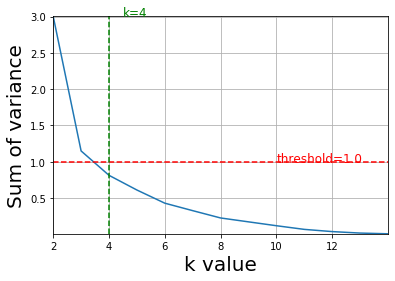

In [18]:
km.plot_elbow_curve()

In [28]:
results_kmeans.cl_mean_centroids

array([[ 80.36093903, 126.01826986,  57.59510956,  80.36093903,
        104.16859945],
       [ 80.36093903, 126.01826986,  57.59510956,  57.59510956,
        104.16859945],
       [ 80.36093903, 126.01826986,  57.59510956,  57.59510956,
        104.16859945]])

## Inspecting the results 

In [19]:
time_clusters = xr.DataArray(results.row_clusters, dims='time', 
                             coords=spring_index.time.coords, 
                             name='time cluster')
space_clusters = xr.DataArray(results.col_clusters, dims='space', 
                              coords=spring_index.space.coords, 
                              name='space cluster')

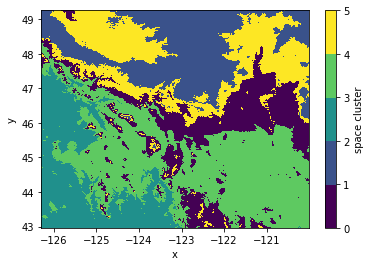

In [20]:
space_clusters_xy = space_clusters.unstack('space')
space_clusters_xy.plot.imshow(x='x', y='y', levels=range(num_space_clusters+1))

(array([5., 5., 5.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <a list of 3 Patch objects>)

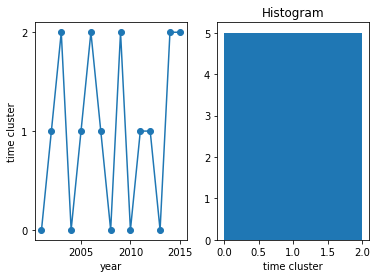

In [21]:
fig, ax = plt.subplots(1, 2)
time_clusters.plot(ax=ax[0], x='year', marker='o')
ax[0].set_yticks(range(num_time_clusters))
time_clusters.plot.hist(ax=ax[1], bins=num_time_clusters)

In [22]:
spring_index = spring_index.assign_coords(time_clusters=time_clusters, 
                                          space_clusters=space_clusters)

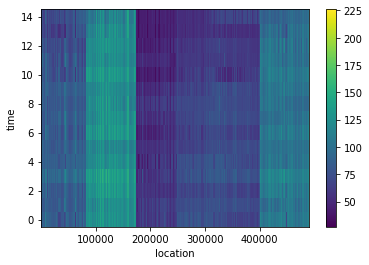

In [23]:
spring_index_sorted = spring_index.sortby(['time_clusters', 
                                           'space_clusters'])
ax = spring_index_sorted.plot.imshow(x='location', y='time')

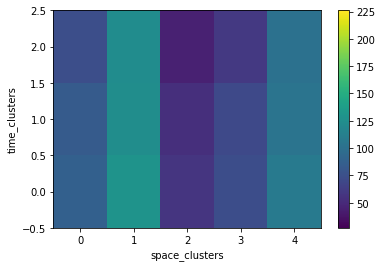

In [24]:
spring_index_vs_clusters = spring_index.set_index(
    {'time': 'time_clusters', 'space': 'space_clusters'}
)
stacked = spring_index_vs_clusters.stack(clusters=('time', 'space'))
means = stacked.groupby('clusters').mean().unstack('clusters')
means = means.rename({'clusters_level_0': 'time_clusters', 
                      'clusters_level_1': 'space_clusters'})
means.plot.imshow(vmin=ax.colorbar.vmin, vmax=ax.colorbar.vmax)

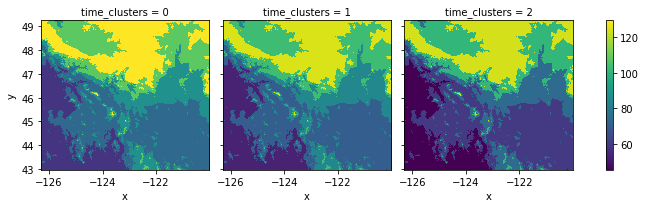

In [25]:
space_means = means[:, space_clusters].unstack('space')
space_means.plot.imshow(x='x', y='y', col='time_clusters')

In [26]:
means.data = results_kmeans.cl_mean_centroids

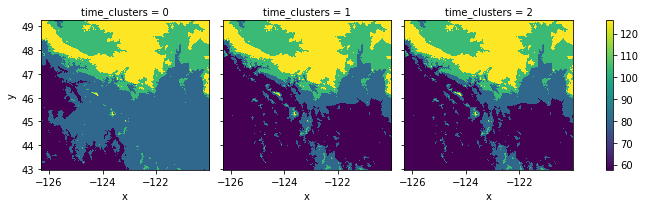

In [27]:
space_means_refined = means[:, space_clusters].unstack('space')
space_means_refined.plot.imshow(x='x', y='y', col='time_clusters')